In [1]:
import os
import pickle
import numpy as np

import fitsio

import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 0


/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# load `SpenderQ` model

In [4]:
niter = 3
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


# load batch

In [5]:
ibatch = 301 

with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [6]:
# load true continuum
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

In [7]:
picca = U.london_picca()

# run `SpenderQ`

In [8]:
with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

# assess performance

/tmp/ipykernel_947282/3493095316.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


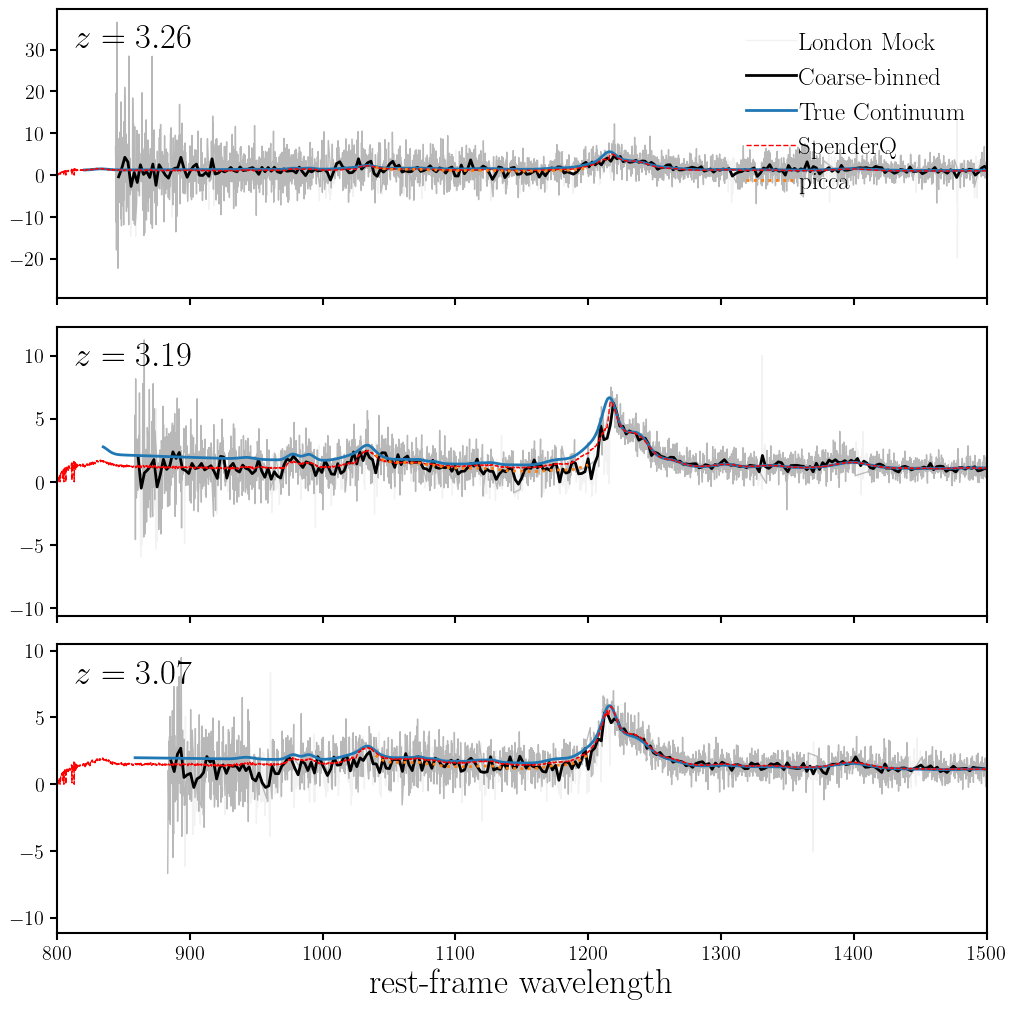

In [9]:
highzs = np.arange(len(z))[z > 3.0][22:25]

fig = plt.figure(figsize=(12,4*len(highzs)))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.1, lw=1, label='London Mock')
    sub.plot((models[0].wave_obs/(1 + z[igal]))[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=2, label='Coarse-binned')

    # true continuum
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1 + z[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    
    # SpenderQ
    sub.plot(models[0].wave_rest, spec_rest[igal], color='r', lw=1, ls='--', label='SpenderQ')
    
    # picca
    spec_picca = picca.get_continuum(int(target_id[igal]))
    sub.plot(picca.wave_picca, spec_picca/norm[igal], color='C1', lw=2, ls=':', label='picca')

    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_rest[0], 1500.)#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

/tmp/ipykernel_947282/337571077.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


95
525
393


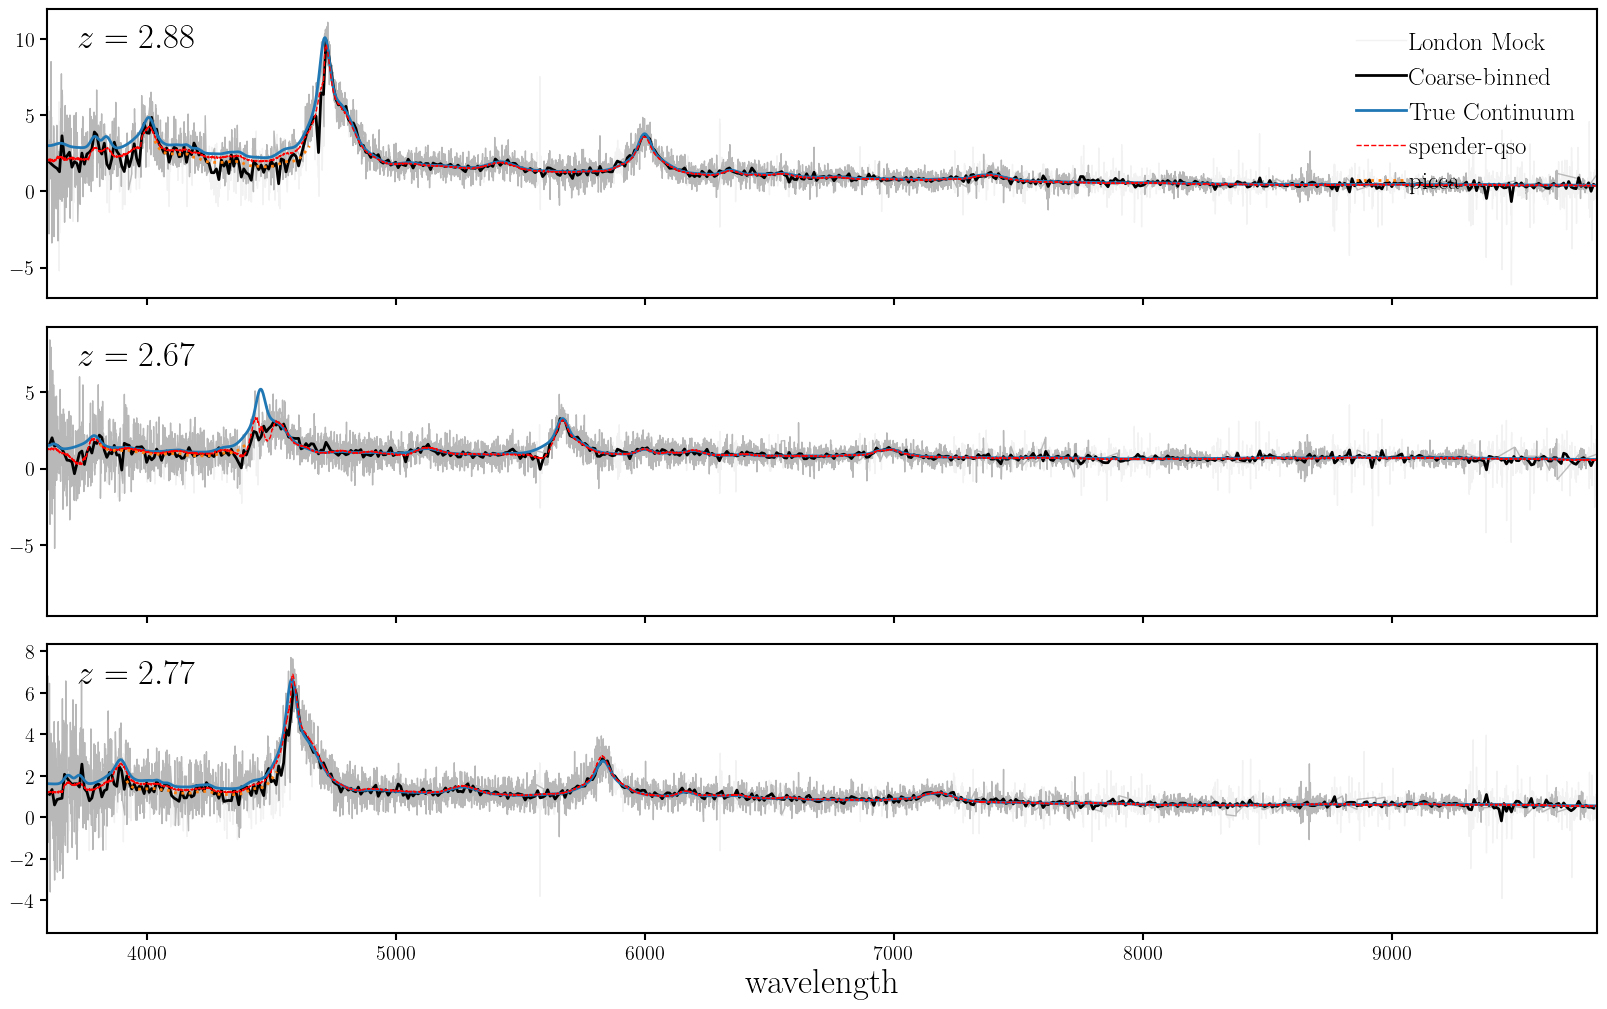

In [10]:
fig = plt.figure(figsize=(20,12))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate([95, 525, 393]): #np.random.choice(np.arange(len(z)), size=3, replace=False)):
    print(igal)
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.1, lw=1, label='London Mock')
    sub.plot((models[0].wave_obs)[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)    

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=2, label='Coarse-binned')

    sub.plot(np.linspace(3.50e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    sub.plot(models[0].wave_rest * (1+z[igal]), spec_rest[igal], color='r', lw=1, ls='--', label='spender-qso')
    
        
    # picca
    spec_picca = picca.get_continuum(int(target_id[igal]))
    sub.plot(picca.wave_picca * (1+float(z[igal])), spec_picca/norm[igal], color='C1', lw=2, ls=':', label='picca')
    
    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
sub.set_xlabel("wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

## quantitative assessment of performance

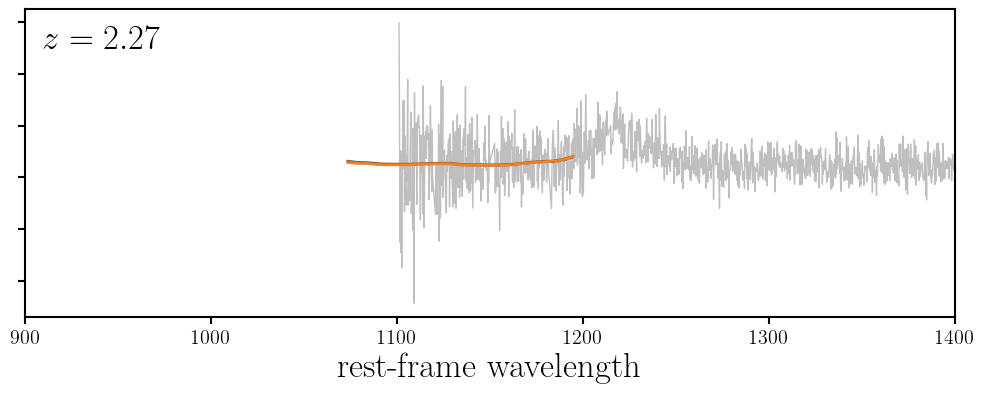

negative slope
no fit
negative slope


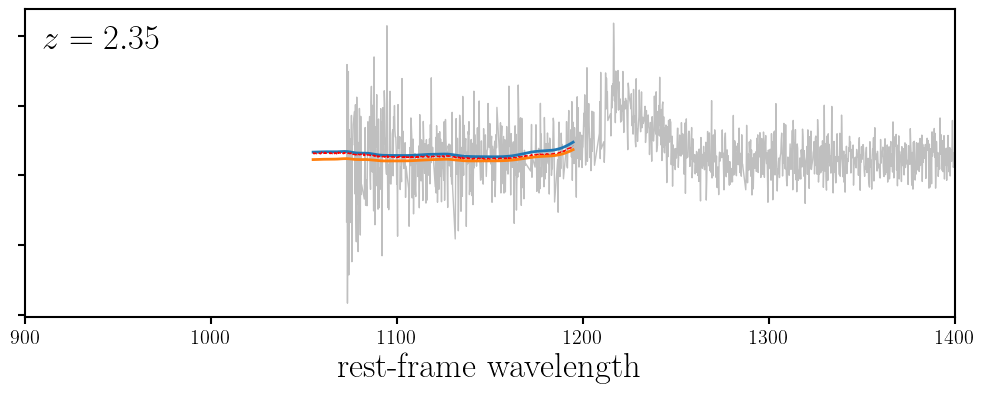

no fit
no fit
negative slope
negative slope
no fit


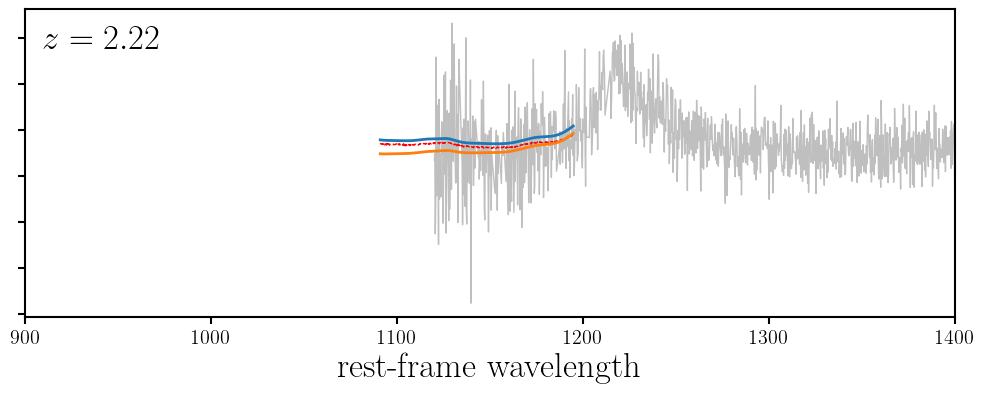

negative slope
no fit
no fit
negative slope


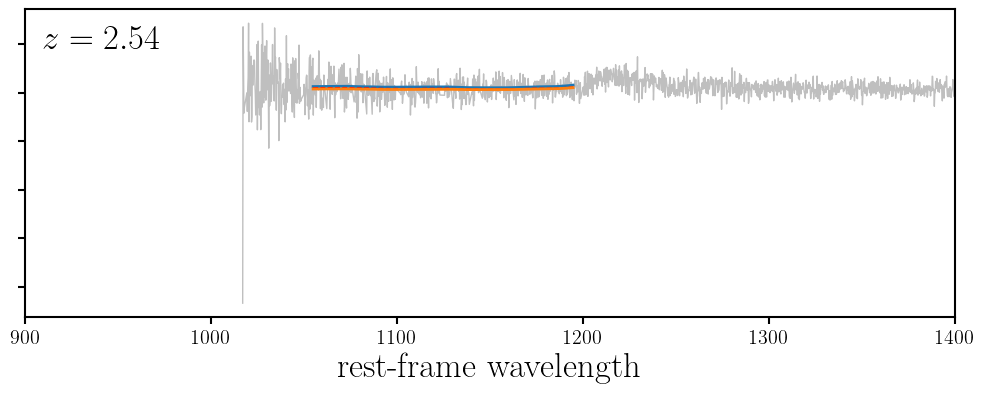

no fit
no fit
negative slope
no fit
negative slope
negative slope


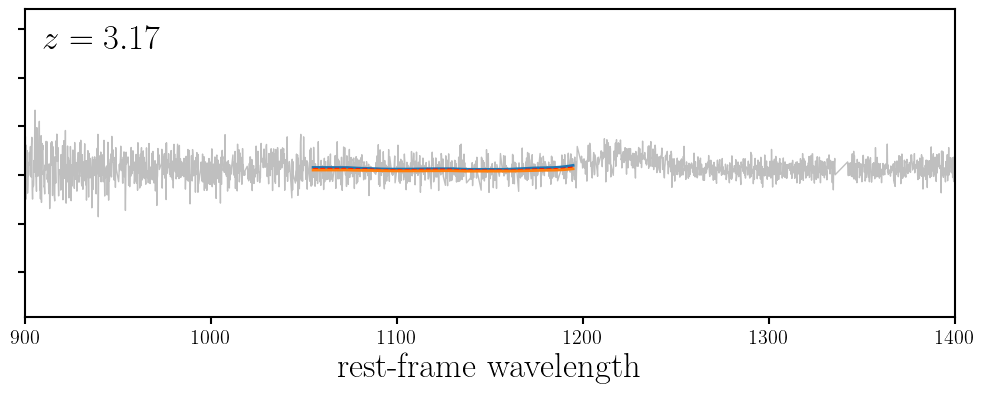

no fit
no fit
negative slope
no fit
no fit


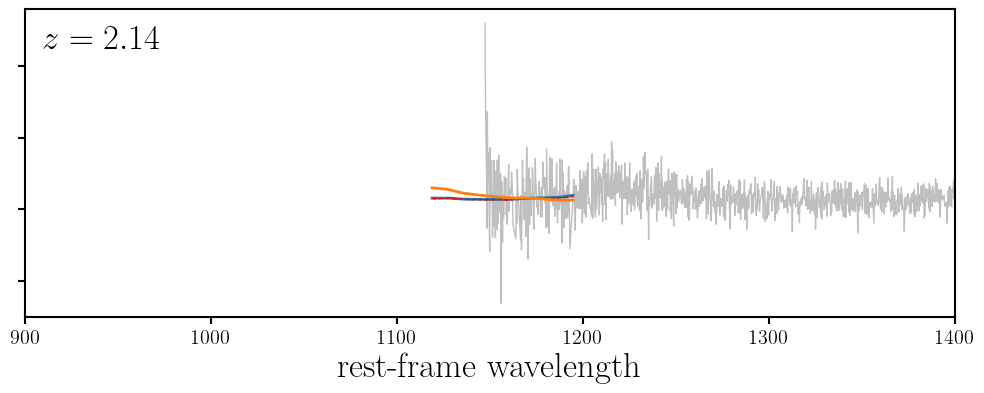

negative slope
no fit
negative slope
negative slope
negative slope
negative slope
negative slope
negative slope
negative slope
negative slope


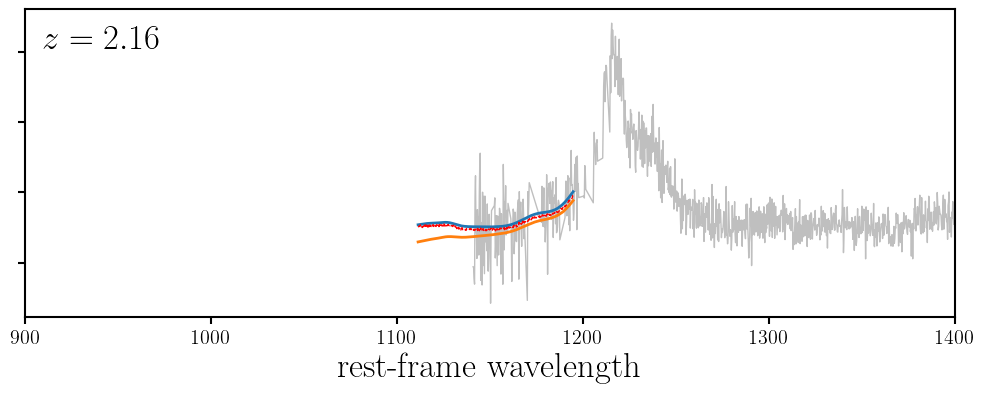

negative slope
negative slope
no fit
negative slope
no fit
negative slope


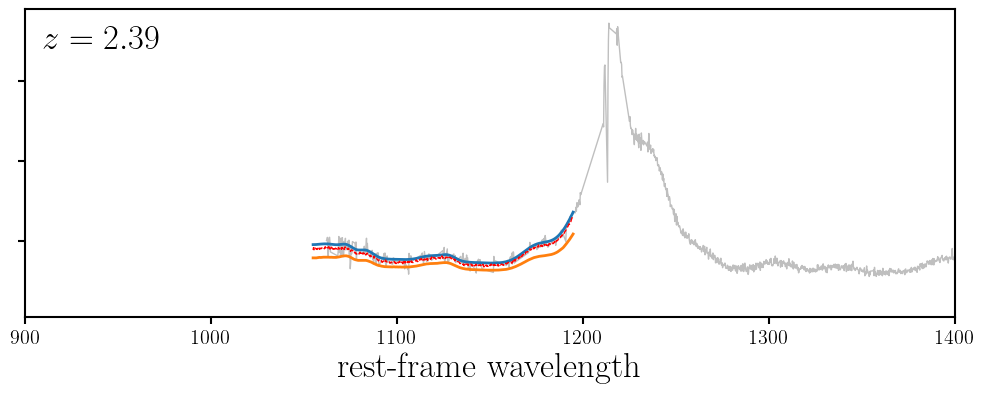

negative slope
no fit
no fit


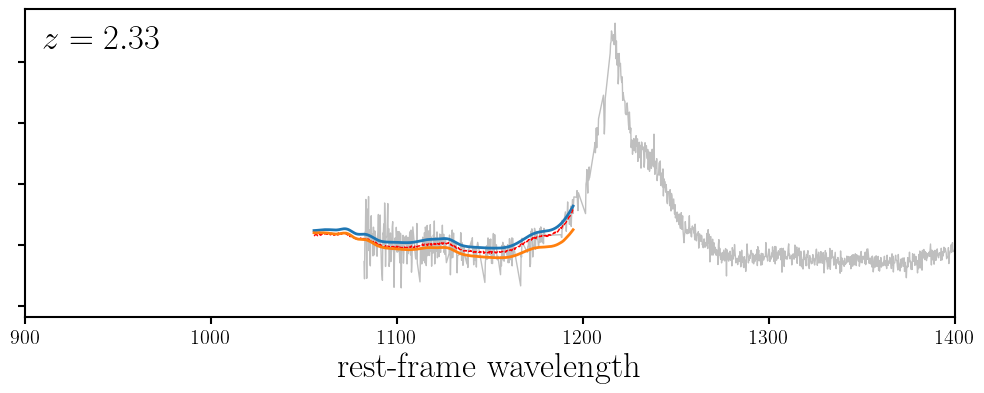

negative slope
no fit
no fit
negative slope
negative slope


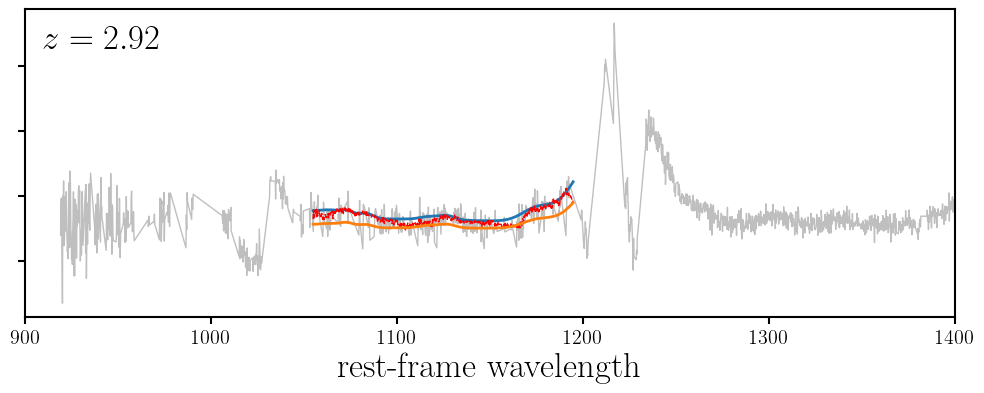

no fit
no fit
no fit
no fit
negative slope
negative slope
negative slope
no fit
negative slope


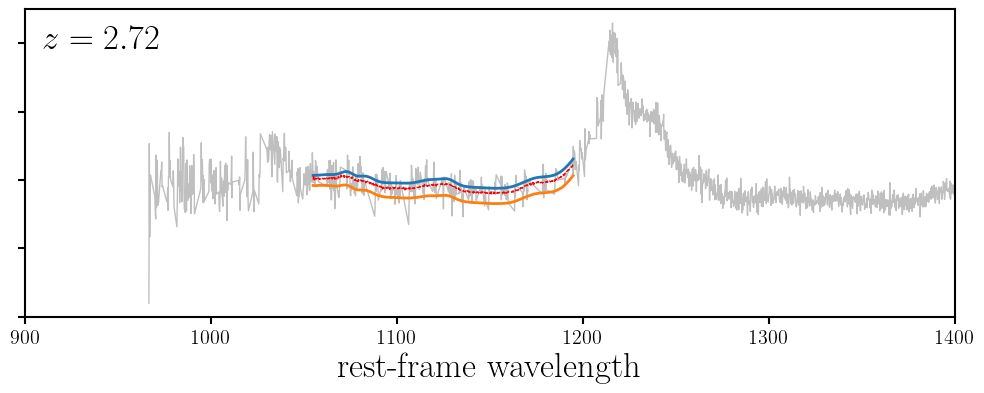

negative slope


In [11]:
dcont_rebin, dcont_picca = [], []
for igal in range(len(z)): 
    
    wlim = (models[0].wave_rest > np.max([1055., 3.51e3/(1+z[igal])])) & (models[0].wave_rest < 1195.)

    cont_rebin = U.trapz_rebin(np.array(np.linspace(3.50e3, 1e4, 3251)/(1 + z[igal])), np.array(true_cont[igal]/norm[igal]), 
                               xnew=np.array(models[0].wave_rest[wlim]))
    
    _dcont_rebin = np.repeat(-999., len(models[0].wave_rest))
    _dcont_rebin[wlim] = cont_rebin - np.array(spec_rest[igal])[wlim]
    
    dcont_rebin.append(_dcont_rebin)
    
    _dcont_picca = np.repeat(-999., len(models[0].wave_rest))
    
    fpicca = picca.get_continuum(int(target_id[igal]))
    if fpicca is not None: 
        fpicca /= np.array(norm[igal])
        picca_rebin = U.trapz_rebin(picca.wave_picca, fpicca, xnew=np.array(models[0].wave_rest[wlim]))
        _dcont_picca[wlim] = cont_rebin - picca_rebin
    dcont_picca.append(_dcont_picca)
    
    if igal % 100 == 0: 
        fig = plt.figure(figsize=(12,4))
        sub = fig.add_subplot(111)
        sub.plot((models[0].wave_obs/(1 + z[igal]))[w[igal] > 0], (spec[igal])[w[igal] > 0], 
                 c='gray', alpha=0.5, lw=1, label='London Mock')
    
        sub.plot(models[0].wave_rest[wlim], cont_rebin, c='C0', lw=2, label='True Continuum')
        sub.plot(models[0].wave_rest[wlim], spec_rest[igal][wlim], color='r', lw=1, ls='--', label='SpenderQ')
        if fpicca is not None: 
            
            sub.plot(models[0].wave_rest[wlim], picca_rebin, c='C1', lw=2)   
        
        sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)
        
        sub.set_xlim(900., 1400.)
        sub.set_xlabel("rest-frame wavelength", fontsize=25)
        sub.set_yticklabels([])
        plt.show()
        
dcont_rebin = np.array(dcont_rebin)
dcont_picca = np.array(dcont_picca)

In [12]:
picca_fail = np.all(dcont_picca == -999, axis=1)
print(np.sum(picca_fail))

25


In [13]:
# spenderq performance on QSO with picca 
dcont_q0, dcont_q1, dcont_q2, dcont_q3, dcont_q4 = np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest))
for i in np.arange(len(models[0].wave_rest)): 
    has_spectra = (dcont_rebin[:,i] != -999.) & ~picca_fail

    if np.sum(has_spectra): 
        q0, q1, q2, q3, q4 = np.quantile(dcont_rebin[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dcont_q0[i] = q0
        dcont_q1[i] = q1    
        dcont_q2[i] = q2
        dcont_q3[i] = q3
        dcont_q4[i] = q4        

In [14]:
# spender q performance on QSO without picca
dcont_q0_failed, dcont_q1_failed, dcont_q2_failed, dcont_q3_failed, dcont_q4_failed = np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest))
for i in np.arange(len(models[0].wave_rest)): 
    has_spectra = (dcont_rebin[:,i] != -999.) & picca_fail

    if np.sum(has_spectra): 
        q0, q1, q2, q3, q4 = np.quantile(dcont_rebin[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dcont_q0_failed[i] = q0
        dcont_q1_failed[i] = q1    
        dcont_q2_failed[i] = q2
        dcont_q3_failed[i] = q3
        dcont_q4_failed[i] = q4        

In [15]:
# picca performance on QSO with picca
dcont_q0_picca, dcont_q1_picca, dcont_q2_picca, dcont_q3_picca, dcont_q4_picca = np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest)), np.zeros(len(models[0].wave_rest))
for i in np.arange(len(models[0].wave_rest)): 
    has_spectra = (dcont_picca[:,i] != -999.)

    if np.sum(has_spectra): 
        q0, q1, q2, q3, q4 = np.quantile(dcont_picca[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dcont_q0_picca[i] = q0
        dcont_q1_picca[i] = q1    
        dcont_q2_picca[i] = q2
        dcont_q3_picca[i] = q3
        dcont_q4_picca[i] = q4        

(-0.5, 1.0)

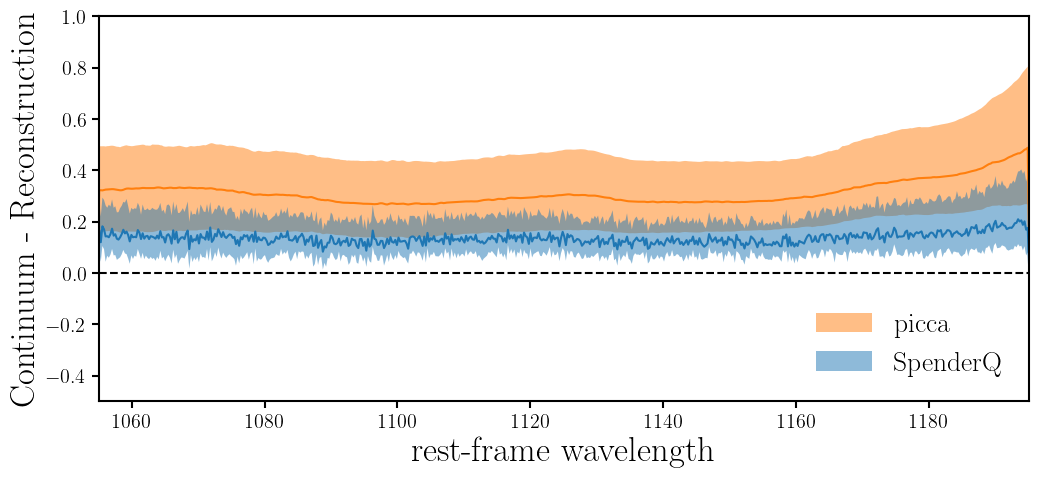

In [16]:
fig = plt.figure(figsize=(12,5))    
sub = fig.add_subplot(111)

#sub.fill_between(models[0].wave_rest, dcont_q0_picca, dcont_q4_picca, color='C1', edgecolor='none', alpha=0.1)
sub.fill_between(models[0].wave_rest, dcont_q1_picca, dcont_q3_picca, color='C1', edgecolor='none', alpha=0.5, label='picca')
sub.plot(models[0].wave_rest, dcont_q2_picca, color='C1')

#sub.fill_between(models[0].wave_rest, dcont_q0, dcont_q4, color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(models[0].wave_rest, dcont_q1, dcont_q3, color='C0', edgecolor='none', alpha=0.5, label='SpenderQ')
sub.plot(models[0].wave_rest, dcont_q2, color='C0')

sub.legend(loc='lower right', fontsize=20)
sub.axhline(0., color='k', linestyle='--')
sub.set_xlabel("rest-frame wavelength", fontsize=25)
sub.set_xlim(1055., 1195.)
sub.set_ylabel('Continuum - Reconstruction', fontsize=25)
sub.set_ylim(-0.5, 1.)

Text(0.5, 1.0, 'objects where picca fail')

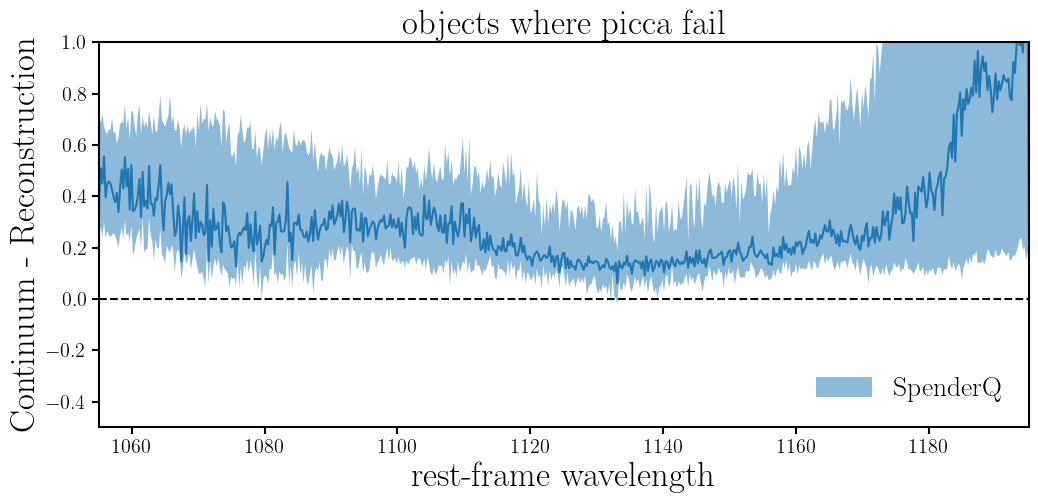

In [17]:
fig = plt.figure(figsize=(12,5))    
sub = fig.add_subplot(111)


#sub.fill_between(models[0].wave_rest, dcont_q0, dcont_q4, color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(models[0].wave_rest, dcont_q1_failed, dcont_q3_failed, color='C0', edgecolor='none', alpha=0.5, label='SpenderQ')
sub.plot(models[0].wave_rest, dcont_q2_failed, color='C0')

sub.legend(loc='lower right', fontsize=20)
sub.axhline(0., color='k', linestyle='--')
sub.set_xlabel("rest-frame wavelength", fontsize=25)
sub.set_xlim(1055., 1195.)
sub.set_ylabel('Continuum - Reconstruction', fontsize=25)
sub.set_ylim(-0.5, 1.)
sub.set_title("objects where picca fail", fontsize=25)

# original reconstruction

(-1.5, 4.0)

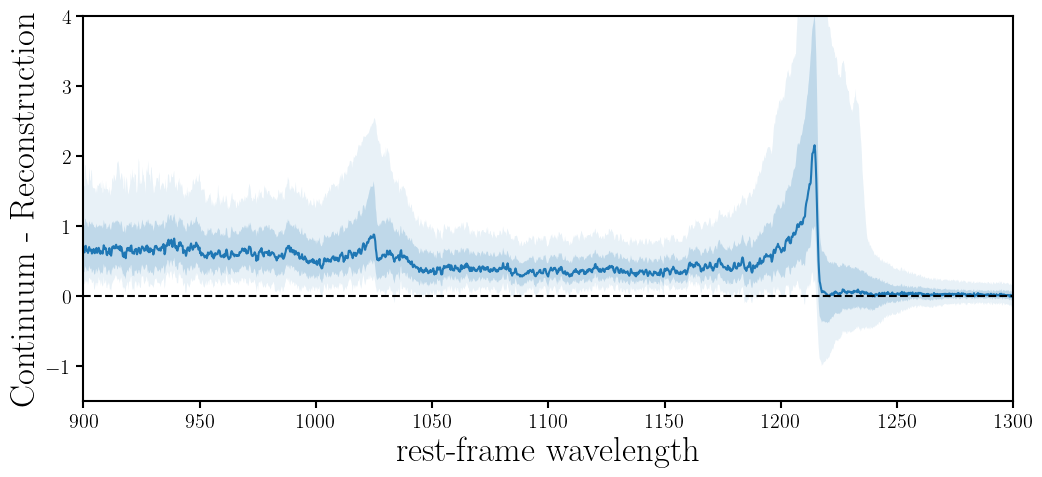

In [35]:
fig = plt.figure(figsize=(12,5))    
sub = fig.add_subplot(111)

sub.fill_between(models[0].wave_rest, dcont_q0, dcont_q4, color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(models[0].wave_rest, dcont_q1, dcont_q3, color='C0', edgecolor='none', alpha=0.2)
sub.plot(models[0].wave_rest, dcont_q2, color='C0')

sub.axhline(0., color='k', linestyle='--')
sub.set_xlabel("rest-frame wavelength", fontsize=25)
sub.set_xlim(900., 1300.)
sub.set_ylabel('Continuum - Reconstruction', fontsize=25)
sub.set_ylim(-1.5, 4.)